# Keras Workflow Example

Dieses Notebook zeigt einen einfachen Workflow zur Verwendung von Keras zum Erstellen, Kompilieren und Trainieren eines voll verbundenen neuronalen Netzwerks (fcNN) zur Klassifizierung der MNIST-Daten.

> Beispiel basiert auf Vorlesungsinhalt, Originalquelle: [Github IOSKN MLDL_HTWG](https://github.com/ioskn/mldl_htwg/blob/master/keras/nb_ch02_02a.ipynb)

## 1. Requirements

Um mit Keras zu arbeiten und für dieses Beispiel werden folgende Bibliotheken benötigt:
- TensorFlow
- Keras
- NumPy
- Jax

### 1.1 Import und Versionen prüfen

Das Keras-Backend ist standardmäßig TensorFlow. Dies kann wie unten gezeigt z.B. auf `Jax` geändert werden.

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"
# os.environ["KERAS_BACKEND"] = "tensorflow"
# os.environ["KERAS_BACKEND"] = "torch"

Auf nicht nativen Unix-Systemen (wie z.B. Windows WSL oder MacOS) ist die Nutzung der GPU nur eingeschränkt bzw. gar nicht möglich. Daher kann festgelegt werden, dass nur die CPU genutzt wird.

In [2]:
os.environ["JAX_PLATFORMS"] = "cpu"

Anschließend kann `keras` importiert und die Versionen der genutzten Bibliotheken überprüft werden. Wurde die Backend-Umgebung korrekt z.B. auf `Jax` gesetzt, so sollte die Ausgabe für das Backend wie folgt aussehen: `keras.backend.backend(): jax`.

In [3]:
import keras

# Inspect Keras/TensorFlow versions and backend
print("KERAS_BACKEND env:", os.environ.get("KERAS_BACKEND"))
print("keras.__version__:", getattr(keras, "__version__", "unknown"))
try:
    from keras.backend import backend as kb_backend
    print("keras.backend.backend():", kb_backend())
except Exception as e:
    print("keras.backend.backend() unavailable:", e)
try:
    import tensorflow as tf
    print("tensorflow.__version__:", tf.__version__)
except Exception as e:
    print("TensorFlow import failed:", e)

/home/simon/MSI-DL/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


KERAS_BACKEND env: jax
keras.__version__: 3.13.0
keras.backend.backend(): jax
tensorflow.__version__: 2.20.0


## 2. Dataset
Wie in den vorherigen Beispielen wird das MNIST-Dataset genutzt welches wie folgt geladen und vorverarbeitet wird:

### 2.1 Lader der Daten und Umwandlung in One-Hot-Encoding

Hier laden wir den MNIST-Datensatz aus Keras. Die 8-Bit-Graustufenbilder haben Werte von 0 bis 255. Wir dividieren alle Werte durch 255, sodass die Werte in einem Bereich zwischen 0 und 1 liegen. Zusätzlich transformieren wir die tatsächlichen Labels, also die Zahlen von 0 bis 9 (die Ziffer auf dem Bild), in die **One-Hot-Kodierung**, um bei der Berechnung des **Kreuzentropieverlusts** lineare Algebra zu nutzen.

Die One-Hot-Kodierung wandelt die Labels in einen Vektor um, dessen *Länge der Anzahl der Labels* entspricht (in unserem Fall 10). Der resultierende Vektor in der One-Hot-Kodierung ist überall Null, außer an der Position des wahren Labels, wo er 1 ist. Anbei einige Beispiele an, um dies zu verdeutlichen:

`0` wird zu `[1,0,0,0,0,0,0,0,0,0]`<br>
`1` wird zu `[0,1,0,0,0,0,0,0,0,0]`<br>
`2` wird zu `[0,0,1,0,0,0,0,0,0,0]`<br>
`3` wird zu `[0,0,0,1,0,0,0,0,0,0]`<br>
...<br>
`9` wird zu `[0,0,0,0,0,0,0,0,0,1]`

In [8]:
import numpy as np
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# separate x_train in X_train and X_val, same for y_train
X_train=x_train[0:50000] / 255 #divide by 255 so that they are in range 0 to 1
Y_train=keras.utils.to_categorical(y_train[0:50000],10) # one-hot encoding

X_val=x_train[50000:60000] / 255
Y_val=keras.utils.to_categorical(y_train[50000:60000],10)

X_test=x_test / 255
Y_test=keras.utils.to_categorical(y_test,10)

del x_train, y_train, x_test, y_test

X_train=np.reshape(X_train, (X_train.shape[0],28,28,1))
X_val=np.reshape(X_val, (X_val.shape[0],28,28,1))
X_test=np.reshape(X_test, (X_test.shape[0],28,28,1))

print(f"X_train_shape:\t{X_train.shape}")
print(f"X_val_shape:\t{X_val.shape}")
print(f"X_test_shape:\t{X_test.shape}")
print(f"Y_train_shape:\t{Y_train.shape}")
print(f"Y_val_shape:\t{Y_val.shape}")
print(f"Y_test_shape:\t{Y_test.shape}")

X_train_shape:	(50000, 28, 28, 1)
X_val_shape:	(10000, 28, 28, 1)
X_test_shape:	(10000, 28, 28, 1)
Y_train_shape:	(50000, 10)
Y_val_shape:	(10000, 10)
Y_test_shape:	(10000, 10)


### 2.2 Datenvisualisierung

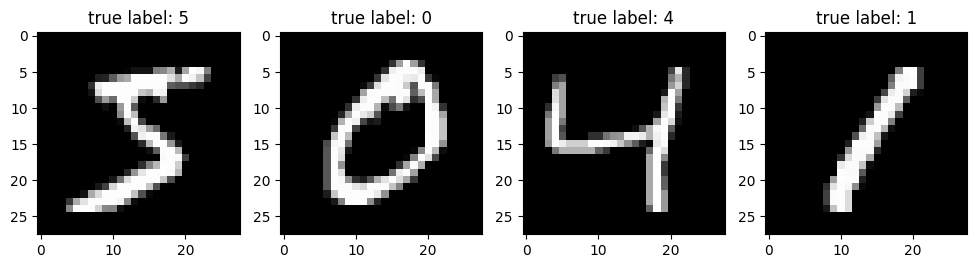

In [10]:
import matplotlib.pyplot as plt

# visualize the 4 first mnist images before shuffling the pixels
plt.figure(figsize=(12,12))
for i in range(0,4):
    plt.subplot(1,4,(i+1))
    plt.imshow((X_train[i,:,:,0]),cmap="gray")
    plt.title('true label: '+str(np.argmax(Y_train,axis=1)[i]))
    #plt.axis('off')

## 3. Keras Workflow

Nun möchten wir ein fcNN trainieren, um die MNIST-Daten zu klassifizieren.

- Wir verwenden ein fcNN mit zwei versteckten Schichten und der Sigmoid-Aktivierungsfunktion.
- Wir trainieren es mit den Trainingsdaten und überprüfen die Leistung anhand der Testdaten.

Da wir fcNN verwenden werden, können unsere Eingaben keine Matrizen oder Tensoren sein. Wir müssen unsere Eingaben in einen 1D-Vektor umwandeln. Dies tun wir in der nächsten Zelle mit reshap und sehen uns die resultierende Form der umgewandelten Daten an.

In [19]:
# prepare data for fcNN - we need a vector as input

X_train_flat = X_train.reshape([X_train.shape[0], 784])
X_val_flat = X_val.reshape([X_val.shape[0], 784])
X_test_flat = X_test.reshape([X_test.shape[0], 784])

# check the shape
print(X_train_flat.shape)
print(Y_train.shape)
print(X_val_flat.shape)
print(Y_val.shape)

(50000, 784)
(50000, 10)
(10000, 784)
(10000, 10)


### 3.1 Define the network

Hier definieren wir das Netzwerk. Wir verwenden zwei versteckte Schichten mit 100 und 50 Knoten. In der Ausgabe sagen wir die Wahrscheinlichkeit für die 10 Ziffern mit der Softmax-Aktivierungsfunktion voraus, in den versteckten Schichten verwenden wir die Sigmoid-Aktivierungsfunktion und unser Verlust ist der kategoriale Kreuzentropieverlust.

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation
from keras.optimizers import SGD

In [14]:
input_dim = 784

# define fcNN with 2 hidden layers
model = Sequential()

model.add(Dense(100, input_shape=(input_dim,)))
model.add(Activation('sigmoid'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('softmax'))

/home/simon/MSI-DL/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 3.2 Compile Network

In [17]:
# compile model and intitialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,060 (328.36 KB)

 Trainable params: 84,060 (328.36 KB)

 Non-trainable params: 0 (0.00 B)

### 3.3 Fit Network

In [20]:
# train the model
history=model.fit(X_train_flat, Y_train,
                  batch_size=128,
                  epochs=10,
                  verbose=2,
                  validation_data=(X_val_flat, Y_val)
                 )

Epoch 1/10
391/391 - 2s - 6ms/step - accuracy: 0.7903 - loss: 0.9536 - val_accuracy: 0.9063 - val_loss: 0.3935
Epoch 2/10
391/391 - 1s - 2ms/step - accuracy: 0.9133 - loss: 0.3322 - val_accuracy: 0.9291 - val_loss: 0.2617
Epoch 3/10
391/391 - 1s - 2ms/step - accuracy: 0.9316 - loss: 0.2433 - val_accuracy: 0.9428 - val_loss: 0.2047
Epoch 4/10
391/391 - 1s - 2ms/step - accuracy: 0.9444 - loss: 0.1964 - val_accuracy: 0.9524 - val_loss: 0.1729
Epoch 5/10
391/391 - 1s - 2ms/step - accuracy: 0.9532 - loss: 0.1646 - val_accuracy: 0.9581 - val_loss: 0.1526
Epoch 6/10
391/391 - 1s - 2ms/step - accuracy: 0.9599 - loss: 0.1405 - val_accuracy: 0.9619 - val_loss: 0.1356
Epoch 7/10
391/391 - 1s - 2ms/step - accuracy: 0.9658 - loss: 0.1214 - val_accuracy: 0.9663 - val_loss: 0.1222
Epoch 8/10
391/391 - 1s - 2ms/step - accuracy: 0.9702 - loss: 0.1053 - val_accuracy: 0.9668 - val_loss: 0.1168
Epoch 9/10
391/391 - 1s - 3ms/step - accuracy: 0.9738 - loss: 0.0927 - val_accuracy: 0.9689 - val_loss: 0.1094
E

In der nächsten Zelle stellen wir die Genauigkeit und den Verlust des Trainings und der Validierung im Vergleich zur Anzahl der Trainingsläufe dar, um zu sehen, wie sich die Entwicklung verläuft.

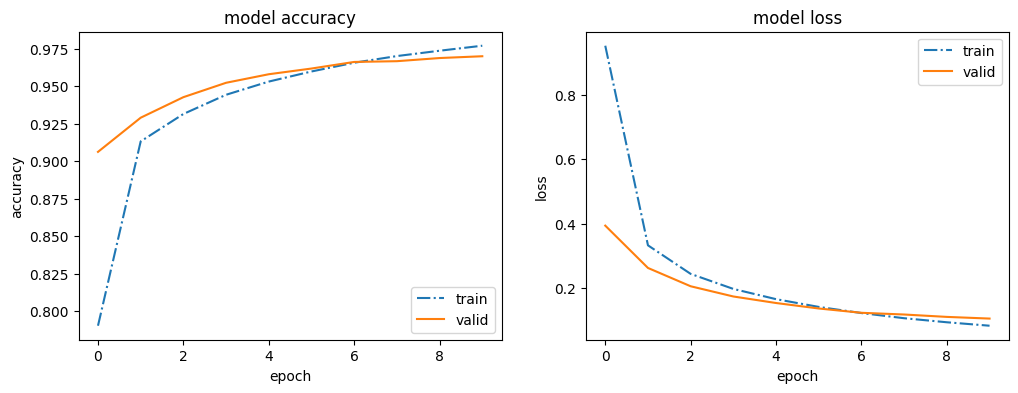

In [22]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

### 3.4 Evaluate Network

Im nächsten Schritt evaluieren wir das trainierte Modell anhand der Testdaten und geben den Testverlust und die Testgenauigkeit aus.

In [24]:
(test_loss, test_accuracy) = model.evaluate(X_test_flat, Y_test, verbose=0)
print(f"Test loss: {test_loss:.8f}, Test accuracy: {test_accuracy:.8}")

Test loss: 0.1054, Test accuracy: 0.9673


### 3.5 Make Predictions
Nun verwenden wir das fcNN, das anhand der abgeflachten MNIST-Daten trainiert wurde, um neue, bisher unbekannte Daten (unsere Testdaten) vorherzusagen. Wir ermitteln die Confusionmatrix und die Genauigkeit anhand der Testdaten, um die Klassifizierungsleistung zu bewerten. Wichtig ist hierbei, dass die Gewichte des Modells nicht verändert werden, da wir das trainierte Modell nur zur Vorhersage verwenden.

In [26]:
model.predict(X_test_flat[0:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


array([[3.9256276e-05, 4.7142988e-05, 4.1939659e-04, 1.8708619e-03,
        3.2169962e-06, 2.1113870e-05, 1.9951592e-08, 9.9745196e-01,
        1.7040125e-05, 1.3000779e-04],
       [1.6786330e-03, 3.6751586e-03, 9.8248672e-01, 9.9342195e-03,
        3.8299099e-06, 5.0377700e-04, 1.3147731e-03, 9.7852644e-05,
        3.0212136e-04, 2.8695670e-06],
       [1.7207634e-05, 9.9637622e-01, 1.2217284e-03, 2.8886250e-04,
        3.5772689e-05, 1.8102088e-04, 5.9385173e-04, 9.4462070e-04,
        3.2688177e-04, 1.3764441e-05],
       [9.9892586e-01, 1.0528008e-05, 2.2070768e-04, 3.7588976e-05,
        2.6807351e-05, 3.4864337e-04, 2.6080103e-04, 6.6384782e-05,
        5.8355436e-06, 9.6986842e-05],
       [7.5753640e-05, 3.5901598e-06, 1.2959617e-04, 3.5484686e-06,
        9.9787521e-01, 6.9786591e-05, 1.5093986e-04, 1.4266922e-04,
        4.2876793e-05, 1.5061114e-03],
       [9.6848435e-06, 9.9683893e-01, 1.8612428e-04, 1.8906163e-04,
        3.7570950e-05, 4.2257023e-05, 2.0922493e-05, 2.46

Mittels Confusionmatrix können wir die Leistung unseres Klassifikators visualisieren, indem wir die tatsächlichen Labels mit den vorhergesagten Labels vergleichen. Die `Acc_fc_orig` Variable speichert die Genauigkeit des Modells auf den Testdaten und sollte mit der Testgenauigkeit übereinstimmen, die wir zuvor berechnet haben.

In [28]:
from sklearn.metrics import confusion_matrix

pred=model.predict(X_test_flat)
print(confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(pred,axis=1)))
acc_fc_orig = np.sum(np.argmax(Y_test,axis=1)==np.argmax(pred,axis=1))/len(pred)
print("Acc_fc_orig_flat = " , acc_fc_orig)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
[[ 972    0    2    1    0    1    2    1    1    0]
 [   0 1119    3    1    0    1    2    2    7    0]
 [   6    1 1001    8    2    0    2    7    5    0]
 [   0    0    3  991    0    4    0    5    7    0]
 [   1    0    3    1  954    0    5    2    2   14]
 [   5    1    0   19    2  844    7    4    6    4]
 [   9    3    4    1    5    8  923    0    5    0]
 [   2    5   14    8    0    0    0  989    1    9]
 [   4    0    5   15    2    4    6    7  929    2]
 [   7    6    2   12   16    5    0    9    1  951]]
Acc_fc_orig_flat =  0.9673
